In [40]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Import functions for data preprocessing & data preparation
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from string import punctuation
import nltk
import re

In [6]:
from facebook_scraper import get_posts

In [7]:
import facebook    #sudo pip install facebook-sdk
import itertools
import json
import re
import requests

In [37]:
import requests
import pandas as pd
import json

page_id = '106743975862287' # your page id, ex: '123456789'
post_id = '122094996674026419' # your post id, ex: '123456789'


url = f'https://graph.facebook.com/v16.0/{page_id}_{post_id}/comments?access_token={access_token}'

response = requests.request("GET", url)

# save name, time, message in excel file
data = json.loads(response.text)

#create object with only name, time, message
def get_comment(comment):
    return {
        'name': comment['from']['name'],
        'time': comment['created_time'],
        'message': comment['message']
    }



excel_data = list(map(get_comment, data['data']))
df = pd.DataFrame(excel_data)
df.head()

,name,time,message
0,Coders,2023-08-25T15:34:06+0000,nice
1,Coders,2023-08-25T15:34:04+0000,great
2,Coders,2023-08-25T15:34:10+0000,lovely
3,Coders,2023-08-25T15:34:08+0000,so good


## CREATING MODEL 

In [38]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
import string
import pandas as pd


# Cleaning Data


In [41]:
snowball_stemer = SnowballStemmer(language="english")
lzr = WordNetLemmatizer()
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/arnavgupta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [44]:
def clean_comments(dataframe: pd.DataFrame):
    dataframe["cleaned"]=(
        dataframe["name"]
        .str.strip()
        .str.replace("\n", " ")
        .str.replace(r"[^\w\s]+", "", regex=True)
        .str.lower()
        .str.replace(r"#\S+", " ", regex=True)
    )
    stop_words=stopwords.words('english')
    punctuations=list(string.punctuation)
    dataframe["cleaned"]=dataframe["cleaned"].apply(lambda comment: " ".join([word for word in comment.split() if word not in stop_words])) #removing stop words
    dataframe["cleaned"]=dataframe["cleaned"].apply(lambda comment: " ".join([word for word in comment.split() if word not in punctuation])) # removing punctuations

    dataframe["cleaned"]=dataframe["cleaned"].apply(lambda comment:" ".join([lzr.lemmatize(word) for word in comment.split()]))#Lemmatization

    #stemming(not recommended )
    #dataframe["cleaned"]=dataframe["cleaned"].apply(lambda comment :" ".join([snowball_stemer.stem(word) for word in comment.split()]))





    return dataframe



    


In [45]:
dfc=clean_comments(df)
dfc.head(10)

,name,time,message,cleaned
0,Coders,2023-08-25T15:34:06+0000,nice,coder
1,Coders,2023-08-25T15:34:04+0000,great,coder
2,Coders,2023-08-25T15:34:10+0000,lovely,coder
3,Coders,2023-08-25T15:34:08+0000,so good,coder


In [46]:
def _get_polarity_score(analyzer: SentimentIntensityAnalyzer, text: str):

    scores = analyzer.polarity_scores(text)
    return scores["compound"]

def _convert_score_to_sentiment(score):
    sentiment = ""

    if score <0.0:
        sentiment = "Negative"
    elif -.05< score <= 0.5:
        sentiment = "Neutral"
    elif score >0.5:
        sentiment = "Positive"

    return sentiment

In [47]:
def test_1(dataframe : pd.DataFrame):
    analyzer=SentimentIntensityAnalyzer()
    dataframe["score"]=dataframe["cleaned"].apply(
        lambda comment : _get_polarity_score(analyzer,comment)
    )

    dataframe["sentiments"]=dataframe["score"].apply(
        lambda score: _convert_score_to_sentiment(score)
    )

    return dataframe

In [48]:
dff=test_1(dfc)
dff

,name,time,message,cleaned,score,sentiments
0,Coders,2023-08-25T15:34:06+0000,nice,coder,0.0,Neutral
1,Coders,2023-08-25T15:34:04+0000,great,coder,0.0,Neutral
2,Coders,2023-08-25T15:34:10+0000,lovely,coder,0.0,Neutral
3,Coders,2023-08-25T15:34:08+0000,so good,coder,0.0,Neutral


In [49]:
sentiment_counts_df = dff["sentiments"].value_counts().to_frame()
sentiment_counts_df.reset_index(inplace=True)
sentiment_counts_df.rename(columns={"index": "Sentiment", "sentiments": "Counts"}, inplace=True)
sentiment_counts_df = sentiment_counts_df.set_index("Sentiment")
sentiment_counts_df


,Counts
Sentiment,
Neutral,4


In [50]:
stats=dff["sentiments"].value_counts()
stats

Neutral    4
Name: sentiments, dtype: int64

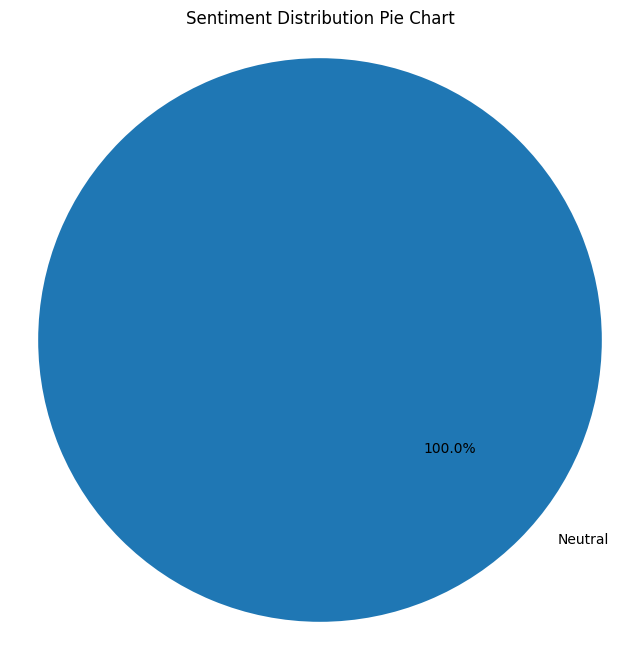

In [51]:
labels = sentiment_counts_df.index
counts = sentiment_counts_df["Counts"]

plt.figure(figsize=(8, 8)) 

max_index = counts.idxmax()
explode = [0.1 if sentiment == max_index else 0 for sentiment in labels]


plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode)

plt.title('Sentiment Distribution Pie Chart')

plt.axis('equal')  
plt.show()
